In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [3]:
import argparse
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import os
from time import strftime
 
from tianshou.data import Batch, Collector, VectorReplayBuffer
from tianshou.trainer import OnpolicyTrainer
from lib.environments import *
from lib.policy import MarlPPOPolicy, IndpPGPolicy
from lib.utils import save_batch_to_file, model_name
from lib.models import *
from lib.custom_tianshou.my_logger import WandbLogger2
import wandb
wandb.require("core")
device = "cuda" if torch.cuda.is_available() else "cpu"

import tianshou as ts
import gymnasium as gym
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time
import seaborn as sns

from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
from tianshou.utils.net.continuous import Actor, Critic, ActorProb


In [4]:
import argparse

# Define the function as it is
def get_args(custom_args=None) -> argparse.Namespace:
    parser = argparse.ArgumentParser()

    parser.add_argument("--algorithm", type=str, default="ppo")
    parser.add_argument("--environment", type=str, default="Kolmogorov11")
    parser.add_argument("--seed", type=int, default=0)

    # ENVIRONMENT ARGUMENTS
    parser.add_argument("--step_factor", type=int, default=1)
    parser.add_argument("--cgs_resolution", type=int, default=1)    
    parser.add_argument("--fgs_resolution", type=int, default=16)
    parser.add_argument("--max_interactions", type=int, default=1587)
    parser.add_argument("--train_num", type=int, default=1)
    parser.add_argument("--test_num", type=int, default=1)

    # POLICY ARGUMENTS
    parser.add_argument("--learning_rate", type=float, default=3e-4)
    parser.add_argument("--adam_eps", type=float, default=1e-7)
    parser.add_argument("--gamma", type=float, default=0.97)
    parser.add_argument("--reward_normalization", type=bool, default=True)
    parser.add_argument("--advantage_normalization", type=bool, default=False)
    parser.add_argument("--recompute_advantage", type=bool, default=False)
    parser.add_argument("--deterministic_eval", type=bool, default=True)
    parser.add_argument("--value_clip", type=bool, default=True)
    parser.add_argument("--action_scaling", type=bool, default=True)
    parser.add_argument("--action_bound_method", type=str, default="tanh")
    parser.add_argument("--ent_coef", type=float, default=1e-4)
    parser.add_argument("--vf_coef", type=float, default=1e-7)
    parser.add_argument("--max_grad_norm", type=float, default=1.)
    parser.add_argument("--gae_lambda", type=float, default=0.9)

    # COLLECTOR ARGUMENTS
    parser.add_argument("--buffer_size", type=int, default=20000)

    # LOGGER ARGUMENTS
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--task", type=str, default="local-omega-learning")

    # TRAINER ARGUMENTS
    parser.add_argument("--max_epoch", type=int, default=10)
    parser.add_argument("--step_per_epoch", type=int, default=1587)
    parser.add_argument("--repeat_per_collect", type=int, default=1)
    parser.add_argument("--episode_per_test", type=int, default=1)
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--step_per_collect", type=int, default=100)
    parser.add_argument("--reward_threshold", type=int, default=100.)

    # If custom_args is passed, use those arguments instead of command line args
    if custom_args:
        return parser.parse_args(custom_args)
    else:
        # This line makes it work in a notebook without command-line args
        return parser.parse_args([])

# Example usage in the notebook by passing arguments as a list
args = get_args([
    '--algorithm', 'ppo',
    '--environment', 'Kolmogorov11',
    '--seed', '42',
    '--max_epoch', '10',
])

print(args)


Namespace(algorithm='ppo', environment='Kolmogorov11', seed=42, step_factor=1, cgs_resolution=1, fgs_resolution=16, max_interactions=1587, train_num=1, test_num=1, learning_rate=0.0003, adam_eps=1e-07, gamma=0.97, reward_normalization=True, advantage_normalization=False, recompute_advantage=False, deterministic_eval=True, value_clip=True, action_scaling=True, action_bound_method='tanh', ent_coef=0.0001, vf_coef=1e-07, max_grad_norm=1.0, gae_lambda=0.9, buffer_size=20000, logdir='log', task='local-omega-learning', max_epoch=10, step_per_epoch=1587, repeat_per_collect=1, episode_per_test=1, batch_size=16, step_per_collect=100, reward_threshold=100.0)


In [5]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [6]:
train_env = gym.make("BipedalWalker-v3", hardcore=False)
test_env = gym.make("BipedalWalker-v3", hardcore=False)
env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")

/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


In [7]:
def show_env(env, step=0, trial=1):
    plt.figure(figsize=(6, 4), dpi=100)
    plt.imshow(env.render())
    plt.axis('off')
    plt.title(f'Trial {trial}, Step {step}')
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    plt.close()


def play_episode2(env):
    #play one episode and record statistics
    reward = 0
    step = 0
    obs ,inf = env.reset()
    episode_is_over = False
    while not episode_is_over:
        show_env(env, step, 1)
        action = env.action_space.sample()
        obs, rew, terminated, truncated, inf = env.step(action)
        reward += rew
        step += 1
        if terminated or truncated:
            episode_is_over = True
    
    print(f"#steps = {step}, Total Reward = {reward}")
    env.close()

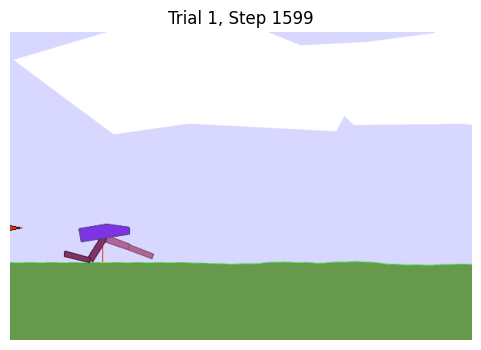

#steps = 1600, Total Reward = -84.54457768580517


In [8]:
play_episode2(env)

In [51]:
print(env.observation_space.shape)
print(env.action_space.shape)

(24,)
(4,)


In [6]:
actor = walker_actor(device=device).to(device)
critic = walker_critic(device=device).to(device)
actor_critic = ActorCritic(actor=actor, critic=critic)
optim = torch.optim.AdamW(actor_critic.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal

In [7]:
policy = PPOPolicy(actor=actor,
        critic=critic,
        optim=optim,
        dist_fn=dist, 
        action_space=train_env.action_space,
        discount_factor=args.gamma,
        reward_normalization=args.reward_normalization, 
        advantage_normalization = args.advantage_normalization,
        value_clip = args.value_clip,
        deterministic_eval=args.deterministic_eval,
        action_scaling=args.action_scaling,
        action_bound_method=args.action_bound_method,
        ent_coef = args.ent_coef,
        vf_coef = args.vf_coef,
        max_grad_norm = args.max_grad_norm,
        gae_lambda=args.gae_lambda, 
        recompute_advantage=args.recompute_advantage,
    )

In [8]:
train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(args.buffer_size, 1))
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/tianshou/data/collector.py:69: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


In [9]:
trainer = OnpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=args.max_epoch,
        step_per_epoch=args.step_per_epoch,
        repeat_per_collect=args.repeat_per_collect,
        episode_per_test=args.episode_per_test,
        batch_size=args.batch_size,
        step_per_collect=args.step_per_collect,
        #episode_per_collect=args.episode_per_collect,
        show_progress=True,
    )

In [10]:
trainer.run()

Epoch #1: 1600it [00:02, 732.00it/s, env_step=1600, len=117, loss=0.935, loss/clip=0.935, loss/ent=0.343, loss/vf=15.002, n/ep=0, n/st=100, rew=-98.32]                          


Epoch #1: test_reward: -16.678583 ± 0.000000, best_reward: -16.521137 ± 0.000000 in #0


Epoch #2:  38%|###7      | 600/1587 [00:00<00:01, 803.32it/s, env_step=2200, len=1600, loss=0.338, loss/clip=0.338, loss/ent=0.342, loss/vf=0.004, n/ep=0, n/st=100, rew=-43.16]


KeyboardInterrupt: 

: 